Date: 2016-10-06

In [1]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2
%qtconsole
import os
import sys
import collections
import random
import itertools
import functools
import scipy.fftpack
import scipy.signal
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as clr
import matplotlib.patches as patches
import seaborn as sns
import pandas as pd
import tqdm
import dask
import dask.multiprocessing

sys.path.append('../src/')
import data_filter
import ripples
import spectral

In [2]:
Animal = collections.namedtuple('Animal', {'directory', 'short_name'})
num_days = 8
days = range(1, num_days + 1)
animals = {'HPa': Animal(directory='HPa_direct', short_name='HPa'),
           'HPc': Animal(directory='HPc_direct', short_name='HPc')}

epoch_info = data_filter.make_epochs_dataframe(animals, days)
tetrode_info = data_filter.make_tetrode_dataframe(animals)
epoch_keys = data_filter.get_dataframe_index(epoch_info
    .loc[(['HPa', 'HPc'], [8]), :]
    .loc[epoch_info.environment == 'wtr1'])

cur_tetrode_info = [tetrode_info[key][tetrode_info[key].area.isin(['PFC', 'CA1'])]
                    for key in epoch_keys]
print(cur_tetrode_info)

tetrode_index = [data_filter.get_dataframe_index(info) for info in cur_tetrode_info]
lfp_data = [data_filter.get_LFP_data(index, animals) for index in tetrode_index]
ripple_times = [ripples._get_computed_consensus_ripple_times(key, animals) for key in epoch_keys]

[                                    area  depth descrip  numcells tetrode_id
animal day epoch_ind tetrode_number                                         
HPa    8   2         1               CA1    113  riptet        12     HPa821
                     2               CA1    121     NaN         0     HPa822
                     3               CA1     90  CA1Ref         0     HPa823
                     4               CA1    116  riptet        15     HPa824
                     5               CA1    116  riptet         0     HPa825
                     6               CA1    110  riptet         0     HPa826
                     7               CA1    114  riptet         0     HPa827
                     15              PFC     93     NaN         0    HPa8215
                     16              PFC     90     NaN         0    HPa8216
                     17              PFC     90     NaN         6    HPa8217
                     18              PFC     90     NaN         0    HPa821

In [3]:
params = dict(
    baseline_window=(-0.250, 0),
    window_of_interest=(-0.250, .250),
    sampling_frequency=1500,
    time_window_duration=0.040,
    time_window_step=0.010,
    desired_frequencies=[100, 300],
    time_halfbandwidth_product=1
)
    
coh = [[spectral.difference_from_baseline_coherence([lfp1, lfp2], epoch_ripple_times, **params)
        for lfp1, lfp2 in itertools.combinations(epoch_lfps, 2)]
       for epoch_lfps, epoch_ripple_times
       in zip(lfp_data, ripple_times)]

## Ripple Times Spectrum

In [4]:
params = dict(
    sampling_frequency=1500,
    time_halfbandwidth_product=12,
)

def convert_ripple_times_to_dataframe(ripple_times, index):
    return (pd.DataFrame({'time': np.array(ripple_times)[:, 0], 'is_ripple': 1})
              .set_index('time')
              .reindex(index=index.values,
                       tolerance=1E-4,
                       method='nearest',
                       fill_value=0))

ripple_psd = [spectral.multitaper_power_spectral_density(
                convert_ripple_times_to_dataframe(epoch_ripple_times, epoch_lfps[0].index), **params)
              for epoch_lfps, epoch_ripple_times
              in zip(lfp_data, ripple_times)]

print(ripple_psd)

[                   power
frequency               
0.000000    2.352191e-07
0.000715    2.325216e-07
0.001431    2.278406e-07
0.002146    2.292224e-07
0.002861    2.198750e-07
0.003576    2.145584e-07
0.004292    2.147742e-07
0.005007    2.126602e-07
0.005722    2.011928e-07
0.006437    1.997727e-07
0.007153    1.922062e-07
0.007868    1.912100e-07
0.008583    1.372965e-07
0.009298    1.277081e-07
0.010014    1.270567e-07
0.010729    1.262861e-07
0.011444    7.367097e-08
0.012159    6.094440e-08
0.012875    5.744894e-08
0.013590    5.558377e-08
0.014305    4.381204e-08
0.015020    4.263989e-08
0.015736    3.935854e-08
0.016451    3.931224e-08
0.017166    2.649375e-08
0.017881    2.788710e-08
0.018597    2.503469e-08
0.019312    2.598572e-08
0.020027    2.306702e-08
0.020742    2.411544e-08
...                  ...
749.979258  3.494920e-08
749.979973  3.877868e-08
749.980688  3.819245e-08
749.981403  4.104216e-08
749.982119  4.201218e-08
749.982834  4.452750e-08
749.983549  4.224576e-08

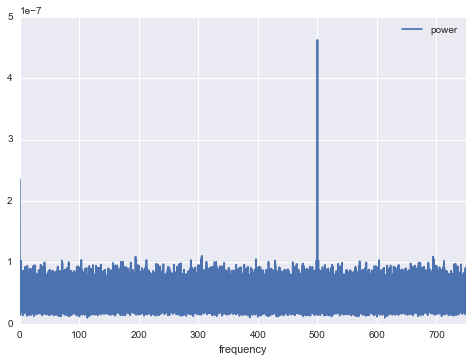

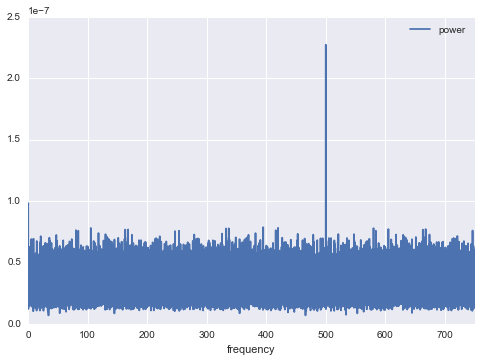

In [5]:
ripple_psd[0].plot()
ripple_psd[1].plot()